# Notebook 2


### To create the map, load libraries in [4] and <a href='#readfiles'>CLICK HERE</a> to go to heading 'Read co-ordinates from CSV files' down below and execute from there sequentially.

Load the libraries required for the exercise

In [1]:
library(ggmap)
library(ggplot2)
library(maptools)
library(maps)
library(dplyr)
library(twitteR)
library(RSQLite) 

Loading required package: ggplot2
Loading required package: sp
Checking rgeos availability: TRUE

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'twitteR'

The following objects are masked from 'package:dplyr':

    id, location



Code to create a SQLite database and connect to it. Commented since I have already put locations and their co-ordinates in CSV files

Reference:

http://geoffjentry.hexdump.org/twitteR.pdf

https://cran.r-project.org/web/packages/twitteR/twitteR.pdf


In [1]:

db <- dbConnect(SQLite(), dbname='Tweets.sqlite')
sql_lite_file = tempfile()
register_sqlite_backend('Tweets.sqlite')


Connect to Twitter using API Keys

In [2]:
setup_twitter_oauth("consumer_key", "consumer_secret", 
                    "access_token", "access_secret")

[1] "Using direct authentication"


Set keyword for searching twitter with hashtag or search term. The tweets collected were tweeted on or after 5th February 2017 (Date of the Superbowl 2017 Final), and since we had to plot the points on the map of the US, I collected tweets within a 1300 mile radius from the center of the US, 5000 at a time, and then stored to the SQLite database. This process was repeated until enough tweets had been collected.

In [ ]:
keyword <- "#Patriots"     #Topic chosen for the tweeets, one of the teams participating in the SuperBowl LI final.

In [5]:
tweets <- searchTwitter(keyword,since='2017-02-05',
                        geocode='37.0902,-95.7129,1300mi',
                        n=5000)
#twListToDF(tweets)


In [6]:
store_tweets_db(tweets)

[1] TRUE

The above process was repeated until we had enough tweets (around 20K). Then we proceed to load the tweets from the database and extract user data and their locations from it.

In [ ]:
tweets_db = load_tweets_db()

Create data frame for storing tweets retrieved from the database

In [8]:
tweetDF <- twListToDF(tweets_db)

In [9]:
users <- lookupUsers(tweetDF$screenName)  #Lookup users

In [10]:
userDF <- twListToDF(users)  #Create a dataframe for user data
userDF <- userDF[-which(userDF$location=="")]   # Remove users where location is blank
locUsers <- !is.na(userDF$location)  # Keep users with locations != NA.
length(locUsers)

[1] 3911

In [11]:
locate <- userDF$location[locatedUsers]

In [12]:
locate1 <-locate[1:1000]
locate2 <-locate[1001:2000]
locate3 <-locate[2001:3000]
locate4 <-locate[3001:4000]

In [13]:
write.csv(locate1, file = "loc1.csv", row.names=FALSE)
write.csv(locate2, file = "loc2.csv", row.names=FALSE)
write.csv(locate3, file = "loc3.csv", row.names=FALSE)
write.csv(locate4, file = "loc4.csv", row.names=FALSE)


Now geocode each location batch of 1000, one by one

In [16]:
locations1 <- geocode(locate1)
write.csv(locations1, file = "cord1.csv", row.names=FALSE)


Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=North%20Hollywood,%20Los%20Angeles&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Boston,%20MA&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=aroud%20the%20world&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Monterrey,%20Nuevo%20Le%C3%B3n&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=ATLANTA%20GA!!!&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco%20del%20Rinc%C3%B3n&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Boston,%20MA&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Taunton,%20MA&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?addres

In [ ]:
locations2 <- geocode(locate2)
write.csv(locations1, file = "cord2.csv", row.names=FALSE)

In [ ]:
locations3 <- geocode(locate3)
write.csv(locations1, file = "cord3.csv", row.names=FALSE)

In [ ]:
locations4 <- geocode(locate4)
write.csv(locations1, file = "cord4.csv", row.names=FALSE)

In [22]:
  geocodeQueryCheck()


500 geocoding queries remaining.


## Read co-ordinates from CSV files  <a id='readfiles'></a>

In [2]:
cord1 = read.csv("cord1.csv", header = TRUE)
cord2 = read.csv("cord2.csv", header = TRUE)
cord3 = read.csv("cord3.csv", header = TRUE)
cord4 = read.csv("cord4.csv", header = TRUE)
cord5 = read.csv("cord5.csv", header = TRUE)     # These are co-ordinates which I had retrieved earlier and stored in a CSV file


Combine the co-ordinates from the CSV files into one object, and then group them together

In [3]:
coord = rbind(cord1,cord2,cord3,cord4,cord5)    #Combine co-ordinates to single object

In [4]:
points=summarise(group_by(coord,lat,lon),count=n())  #Group objects

In [5]:
#write.csv(points, file = "points.csv", row.names=FALSE)   # Write grouped co-ordinates to a file for later use


Load Map and add the points to it. Alpha defines the gradient for the points based on the count, and size is also a factor of the count for a point.

Functions and parameters referenced from:

http://www.statmethods.net/advgraphs/parameters.html

https://www.rdocumentation.org/packages/ggmap/versions/2.6.1/topics/get_map

http://docs.ggplot2.org/0.9.3.1/geom_point.html


In [10]:
map <- get_map(location='united states',color='color',zoom=4,maptype="roadmap",source='google')
m1 <- ggmap(map)              #Load the US Map from Google Maps and store it as p1

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=united+states&zoom=4&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=united%20states&sensor=false


Add the points and call the map on screen.

Warning message:
"Using size for a discrete variable is not advised."

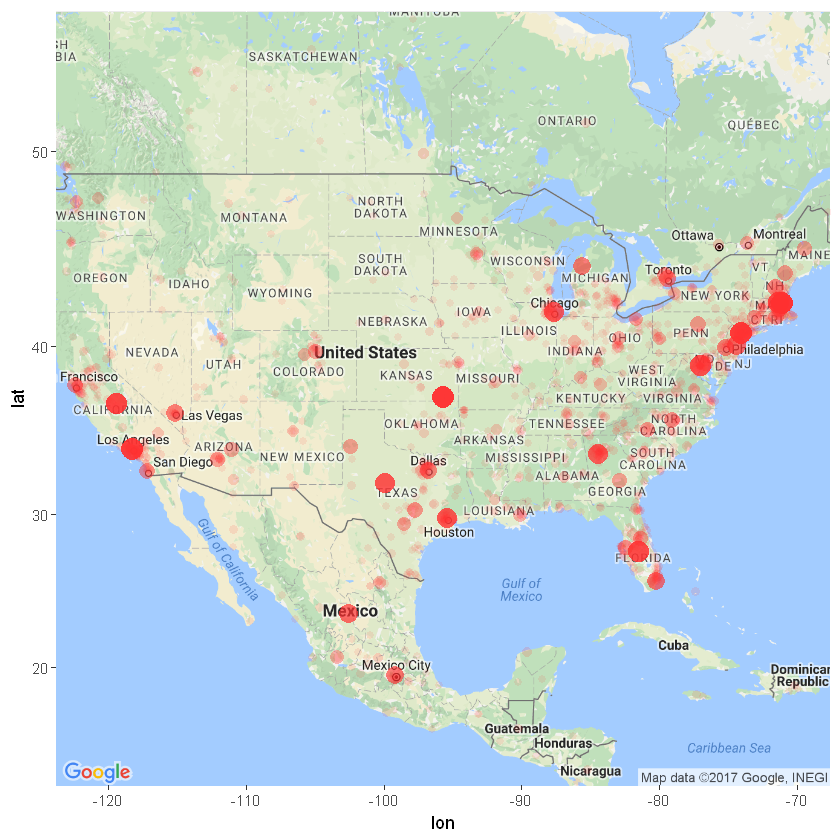

In [11]:
m2 <- m1 + geom_point(data = points,na.rm=TRUE, aes(x = points$lon, y=points$lat,size=factor(points$count), alpha = factor(points$count)),
pch=16,col="firebrick1") + theme(legend.position="none")    #Create Map P2 adding P1 and plotting the points from points
m2

As can be seen in the map, the majority of tweets came from locations in Greater Boston Area, Atlanta (Both areas being home base of the 2 teams in the finals), New York City, Chicago, Orlando, Miami, Washington DC ( or Baltimore) , Houston, Dallas and Los Angeles. Other areas with lower density of tweets are represented by fainter circles all across the map.